# Cancer Cervical PyTorch

In [1]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=6da0798aa9b871b644d25044bcd14802a1453d352ecb94d7f7ac6548ffc6c4e8
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [2]:
!pip install torchsummary

In [3]:
import numpy as np
import math
import sys
import time
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T

# adaugate pt. vizualizare , modele etc..
from torchvision import datasets, models, transforms, utils  # adaugata pentru utils

# adaugat pt. summary
from torchsummary import summary


# pentru vizualizari
from matplotlib import pyplot as plt

# verificare dipozitiv disponibil (de regula GPU)
is_use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if is_use_cuda else "cpu")
print('Platforma de lucru  : ',device)



Platforma de lucru  :  cuda:0


In [6]:
batch_size = 16  # Alegerea depinde de numărul de date
imsize = 96  # dimensiune imagine (pentru redimensionare)

data_set = 'cerv64'
if data_set == 'cerv64':
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(size=(imsize, imsize)),
        torchvision.transforms.ToTensor()
    ])

    train_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/cerv64/cerv64_propriu/train', transform=transform)
    test_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/cerv64/cerv64_propriu/test', transform=transform)
    validation_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/cerv64/cerv64_propriu/val', transform=transform)

    num_classes = 5
    Ntr = len(train_dataset)
    Nts = len(test_dataset)
    Nval = len(validation_dataset)

print('Numar clase: ', num_classes)
print('Numar total esantioane train: ', Ntr)
print('Numar total esantioane test: ', Nts)
print('Numar total esantioane validare: ', Nval)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, num_workers=2, shuffle=True)

#input_shape = next(iter(train_loader))[0].shape[1:]  # Extrage dimensiunea intrării fără dimensiunea batch-ului
#print('Dimensiunea intrare (Canale, Înălțime, Lățime):', input_shape)

input_shape=np.shape(train_loader.dataset[0][0])
print('Dimensionaliate intrare (Chan, Height ,Width): ',input_shape)

classes = train_loader.dataset.classes
print('Numele claselor:', classes)

Numar clase:  5
Numar total esantioane train:  2832
Numar total esantioane test:  609
Numar total esantioane validare:  608
Dimensionaliate intrare (Chan, Height ,Width):  torch.Size([3, 96, 96])
Numele claselor: ['Dyskeratotic', 'Koilocytotic', 'Metaplastic', 'Parabasal', 'Superficial-Intermediate']


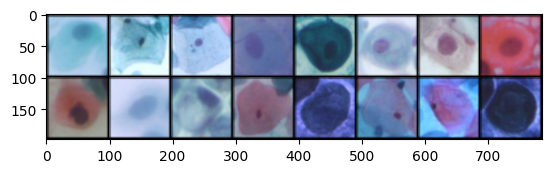

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
inputs, classes = next(iter(train_loader))
out = utils.make_grid(inputs)
imshow(out)


Learning rate per epoch:


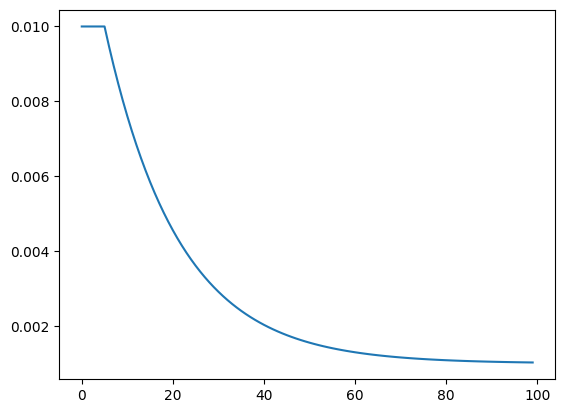

In [8]:
# DEFINIRE FUNCTII ANTRENARE SI TESTARE inclusiv "learning rate schedule" (plan de evolutie a ratei de antrenare)
#
#=========================================================
# adaptat dupa https://github.com/luuuyi/SqueezeNext.PyTorch/blob/master/SqueezeNext.ipynb
rata_antren_constanta=False # True sau False -
num_epochs=100
start_lr=0.01 # rata de antrenare la pornire
criterion = nn.CrossEntropyLoss()


def lr_schedule(start_lr, epoch):
      # parametri evolutie
      #
      if rata_antren_constanta:
        min_lr=start_lr; max_lr=start_lr; exp_decay=1  # rata de antrenare constanta
      else:
        min_lr = 0.001; max_lr = 0.01; exp_decay = .94 # rate de antrenare dupa o schema prestabilita

      rampup_epochs = 5; sustain_epochs = 0;
      if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
      elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
      else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr

# Vizualizare training schedule
from matplotlib import pyplot as plt
rang = np.arange(num_epochs)
y = [lr_schedule(start_lr,x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

# definire bucla de antrenare ------------------------------------------
def train(epoch):
    net.train()
    train_loss = 0
    correct    = 0
    total      = 0
    optimizer  = optim.SGD(net.parameters(), lr=lr_schedule(start_lr, epoch), momentum=0.9, weight_decay=5e-4)
    # se poate utiliza una din cele 2 variante de lr_schedule
    # Aici s-a ales optimizerul SGD
    #optimizer = optim.Adam(net.parameters(),lr=lr_schedule(lr, epoch))

    print('Training Epoch: #%d, LR: %.4f'%(epoch, lr_schedule(start_lr, epoch))) # atentie schimbare lr_schedule
    for idx, (inputs, labels) in enumerate(train_loader):
        if is_use_cuda:
            inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs        = net(inputs)
        loss           = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predict = torch.max(outputs, 1)
        total      += labels.size(0)
        correct    += predict.eq(labels).cpu().sum().double()

        sys.stdout.write('\r')
        sys.stdout.write('[%s] Training Epoch [%d/%d] Iter[%d/%d]\t\tLoss: %.4f Acc@1: %.3f'
                        % (time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())),
                           epoch, num_epochs, idx, len(train_loader),
                          train_loss / ( (idx + 1)), correct / total))
        sys.stdout.flush()

    #print('total: ', total, 'correct: ',correct)
    #print('train-loss: ', train_loss/(idx+1))
    return train_loss/(idx+1) , correct / total  #/ (batch_size * (idx + 1))

# ---------definire bucla de validare inclusiv "checkpoint" cu salvarea modelului optim (acuratete maxima pe validare)
def validation(epoch):
    global best_acc
    net.eval()
    validation_loss = 0
    correct   = 0
    total     = 0

    for idx, (inputs, labels) in enumerate(validation_loader):
        #print(idx)
        if is_use_cuda:
            inputs, labels = inputs.to(device), labels.to(device)
        outputs        = net(inputs)
        loss           = criterion(outputs, labels)

        validation_loss  += loss.item()
        #print('validation loss:',validation_loss)
        _, predict = torch.max(outputs, 1)
        total      += labels.size(0)
        correct    += predict.eq(labels).cpu().sum().double()

        sys.stdout.write('\r')
        sys.stdout.write('[%s] Validation Epoch [%d/%d] Iter[%d/%d]\t\tLoss: %.4f Acc@1: %.3f'
                        % (time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())),
                           epoch, num_epochs, idx, len(validation_loader),   # aici test_batch=80
                          validation_loss / ( (idx + 1)), correct / total))     # aici test_batch=100
        sys.stdout.flush()


    if correct / total > best_acc:
        print()
        print('Saving Model...')
        state = {
                'net': net.module if is_use_cuda else net,
                'acc': correct / total,
                'epoch': epoch
                }
        if not os.path.isdir('./checkpoint/'):
            os.makedirs('./checkpoint/')
        torch.save(state, './checkpoint/best_model.ckpt')
        best_acc = correct / total
    #print('validation-loss: ', validation_loss/(idx+1))
    return validation_loss/ (idx+1) , correct / total  #/ (test_batch * (idx + 1))

In [9]:
from efficientnet_pytorch import EfficientNet; net = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes); net_name='EffB0'


if is_use_cuda:
    net.to(device)
    net = nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
print(input_shape)

summary(net.to(device), input_size = input_shape, batch_size = -1)  # vizualizare model
# Calcul dimensiune model (numar parametri)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Numar parametri model: ',count_parameters(net.to(device)))
def display_training_curves(training, validation, title, subplot):

    if subplot%10==1: # set up the subplots on the first call

        plt.subplots(figsize=(8,2), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    # ax.set_ylim(0,10)

    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 199MB/s]


Loaded pretrained weights for efficientnet-b0
torch.Size([3, 96, 96])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1            [-1, 3, 97, 97]               0
Conv2dStaticSamePadding-2           [-1, 32, 48, 48]             864
       BatchNorm2d-3           [-1, 32, 48, 48]              64
MemoryEfficientSwish-4           [-1, 32, 48, 48]               0
         ZeroPad2d-5           [-1, 32, 50, 50]               0
Conv2dStaticSamePadding-6           [-1, 32, 48, 48]             288
       BatchNorm2d-7           [-1, 32, 48, 48]              64
MemoryEfficientSwish-8           [-1, 32, 48, 48]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStat

Training Epoch: #1, LR: 0.0100
[2024-05-01 00:02:40] Training Epoch [1/15] Iter[176/177]		Loss: 0.6116 Acc@1: 0.776
[2024-05-01 00:02:45] Validation Epoch [1/15] Iter[37/38]		Loss: 1.6530 Acc@1: 0.472
Saving Model...


Epoch #1 duration: 41s
Training Epoch: #2, LR: 0.0100
[2024-05-01 00:03:20] Training Epoch [2/15] Iter[176/177]		Loss: 0.3855 Acc@1: 0.859
[2024-05-01 00:03:25] Validation Epoch [2/15] Iter[37/38]		Loss: 0.4589 Acc@1: 0.839
Saving Model...


Epoch #2 duration: 40s
Training Epoch: #3, LR: 0.0100
[2024-05-01 00:04:00] Training Epoch [3/15] Iter[176/177]		Loss: 0.2739 Acc@1: 0.905
[2024-05-01 00:04:05] Validation Epoch [3/15] Iter[37/38]		Loss: 0.3558 Acc@1: 0.875
Saving Model...


Epoch #3 duration: 39s
Training Epoch: #4, LR: 0.0100
[2024-05-01 00:04:40] Training Epoch [4/15] Iter[176/177]		Loss: 0.2032 Acc@1: 0.933
[2024-05-01 00:04:45] Validation Epoch [4/15] Iter[37/38]		Loss: 0.2183 Acc@1: 0.928
Saving Model...


Epoch #4 duration: 40s
Training Epoch: #5, LR: 0.0100
[

/tmp/ipykernel_34/3188973529.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


<Figure size 640x480 with 0 Axes>

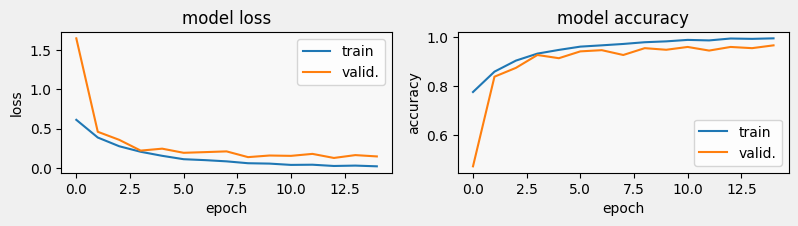

In [10]:
# ANTRENARE SI VALIDARE CU RAPORTARE REZULTATE
#==============================================================
# adaptat dupa https://github.com/luuuyi/SqueezeNext.PyTorch/blob/master/SqueezeNext.ipynb
start_epoch=1
num_epochs=15
best_acc=0.0 #

import time
torch.autograd.set_detect_anomaly(True)
# --- adaugat pentru a monitoriza evolutia -------------------------------
history = {} # Collects per-epoch loss and acc like Keras' fit().
history['loss'] = []
history['val_loss'] = []
history['acc'] = []
history['val_acc'] = []
#-----------------------------------------------------------
for _epoch in range(start_epoch, start_epoch + num_epochs):
    start_time = time.time()
    tr_loss, tr_acc = train(_epoch)
    print()
    validation_loss, validation_acc = validation(_epoch)
    history['loss'].append(tr_loss)
    history['val_loss'].append(validation_loss)
    history['acc'].append(tr_acc)
    history['val_acc'].append(validation_acc)
    print()
    print()
    end_time   = time.time()
    print('Epoch #%d duration: %ds' % (_epoch, end_time - start_time))

print('xxxxxxxxxxxxxxxxxxxxxxx  REPORT xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
print('Dataset :',data_set)
print('Best valid accuracy: %.4f %%' % (best_acc * 100))
print('Numar parametri model: ',count_parameters(net))
print('Batch_size: ', batch_size)
print('Epoci: ', num_epochs)
print('Num_classes: ',num_classes)
print('Input-shape: ',input_shape)
print('Model name: ', net_name)
print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
plt.clf()
display_training_curves(history['loss'], history['val_loss'], 'loss', 121)
#plt.clf()
display_training_curves(history['acc'], history['val_acc'], 'accuracy', 122)


In [11]:
import torch

# Încarcă modelul optim
best = torch.load('./checkpoint/best_model.ckpt')
best_model = best["net"]
best_acc = best['acc']

# Salvează modelul PyTorch
torch.save(best_model, net_name + '__' + str(int(best_acc * 10000)) + '.pt')
print('Ultimele 4 cifre divizate cu 100 indica acuratetea pe date de validare (in %)')


Ultimele 4 cifre divizate cu 100 indica acuratetea pe date de validare (in %)


Etichetă reală: 2
Clasă prezisă: 2


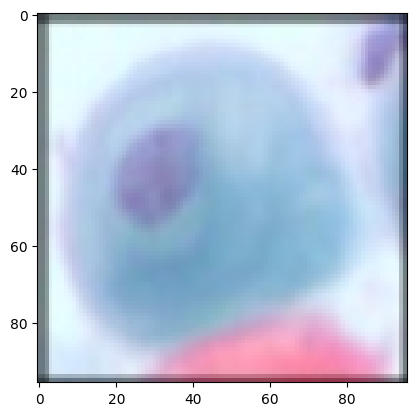

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from efficientnet_pytorch import EfficientNet

# Selectează aleator o imagine din setul de date de testare
selectia = int(len(test_loader.dataset) * np.random.rand(1)[0])
img, label = test_loader.dataset[selectia]

# Afișează imaginea
if img.shape[0] == 1:
    plt.imshow(img.squeeze(), cmap='gray')
elif img.shape[0] == 3:
    plt.imshow(np.transpose(img, (1, 2, 0)))

# Afișează eticheta reală
print('Etichetă reală:', label)

# Încarcă modelul
model_path = "/kaggle/working/EffB0__9671.pt"
net = torch.load(model_path)

# Mută modelul pe CPU (dacă nu ai un GPU disponibil)
net = net.to('cpu')

# Setează modelul în modul de evaluare
net.eval()

# Mută tensorul de intrare pe dispozitivul modelului (CPU)
img = img.unsqueeze(0).to('cpu')

# Efectuează predicția
with torch.no_grad():
    output = net(img)  # Obține predicția modelului
    _, predicted = torch.max(output, 1)  # Obține clasa prezisă
print('Clasă prezisă:', predicted.item())


In [43]:
import torch
from sklearn.metrics import classification_report, confusion_matrix

# Setarea căii către model
model_path = "/kaggle/working/EffB0__9671.pt"

# Încărcarea modelului
net = torch.load(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)

# Resetarea generatorului de testare și definirea acestuia cu batch_size-ul adecvat
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=609, shuffle=False)

# Afișarea numărului de imagini și numărului de clase în setul de date de testare
num_images = len(test_loader.dataset)
num_classes = len(test_loader.dataset.classes)
print(f"Found {num_images} images belonging to {num_classes} classes.")

# Efectuează evaluarea modelului pe setul de date de testare
net.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Mutați datele pe GPU (dacă este disponibil)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)

# Calculează acuratețea
accuracy = (predicted == labels).float().mean()
print(f"Acuratete set test = {accuracy.item()*100} %")

# Calculează matricea de confuzie și alte metrici de performanță
conf_matrix = confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())
print("Matricea de confuzie:")
print(conf_matrix)

# Calculează alte metrici de performanță
print("Raportul de clasificare:")
print(classification_report(labels.cpu().numpy(), predicted.cpu().numpy()))


Found 609 images belonging to 5 classes.
Acuratete set test = 96.38752341270447 %
Matricea de confuzie:
[[119   2   0   1   0]
 [  5 112   5   1   1]
 [  4   0 115   0   0]
 [  0   0   0 118   1]
 [  0   0   0   2 123]]
Raportul de clasificare:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       122
           1       0.98      0.90      0.94       124
           2       0.96      0.97      0.96       119
           3       0.97      0.99      0.98       119
           4       0.98      0.98      0.98       125

    accuracy                           0.96       609
   macro avg       0.96      0.96      0.96       609
weighted avg       0.96      0.96      0.96       609

